# HW1: Data Exploration and Preparation

includes

In [163]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

In [164]:
params ={
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'axes.titlesize' : 22,
    'axes.labelsize': 20,
    'legend.fontsize': 18,
    'legend.title_fontsize': 22,
    'figure.titlesize': 24
}
pylab.rcParams.update(params)

## Par1 :Data Loading and First Look

### Q1

In [165]:
data = pd.read_csv('data/virus_data.csv')
data.shape


(1250, 26)

### Q2

In [166]:
data['conversations_per_day'].value_counts()

1     232
2     213
3     191
4     158
5     127
0     117
6      69
7      46
8      34
9      21
10     20
12      7
11      5
13      4
15      3
14      2
16      1
Name: conversations_per_day, dtype: int64

### Q4

In [167]:
training, test = train_test_split(data, test_size=0.2, random_state=182)

## Part2: Warming up with k-Nearest Neighbors

### Q5

#### corelation between *spread* and *PCR_01*

In [168]:
corr_spread_pcr_1 = training['spread'].corr(training['PCR_01'])
print("The corelation between spread and PCR_01 is: ", corr_spread_pcr_1)

The corelation between spread and PCR_01 is:  0.07982951465773408


#### corelation between *spread* and *PCR_02*

In [169]:
corr_spread_pcr_2 = training['spread'].corr(training['PCR_02'])
print("The corelation between spread and PCR_02 is: ", corr_spread_pcr_2)

The corelation between spread and PCR_02 is:  -0.009443954476544473


#### corelation between *spread* and *PCR_03*

In [170]:
corr_spread_pcr_3 = training['spread'].corr(training['PCR_03'])
print("The corelation between spread and PCR_03 is: ", corr_spread_pcr_3)

The corelation between spread and PCR_03 is:  -0.017015901659546737


### Q6

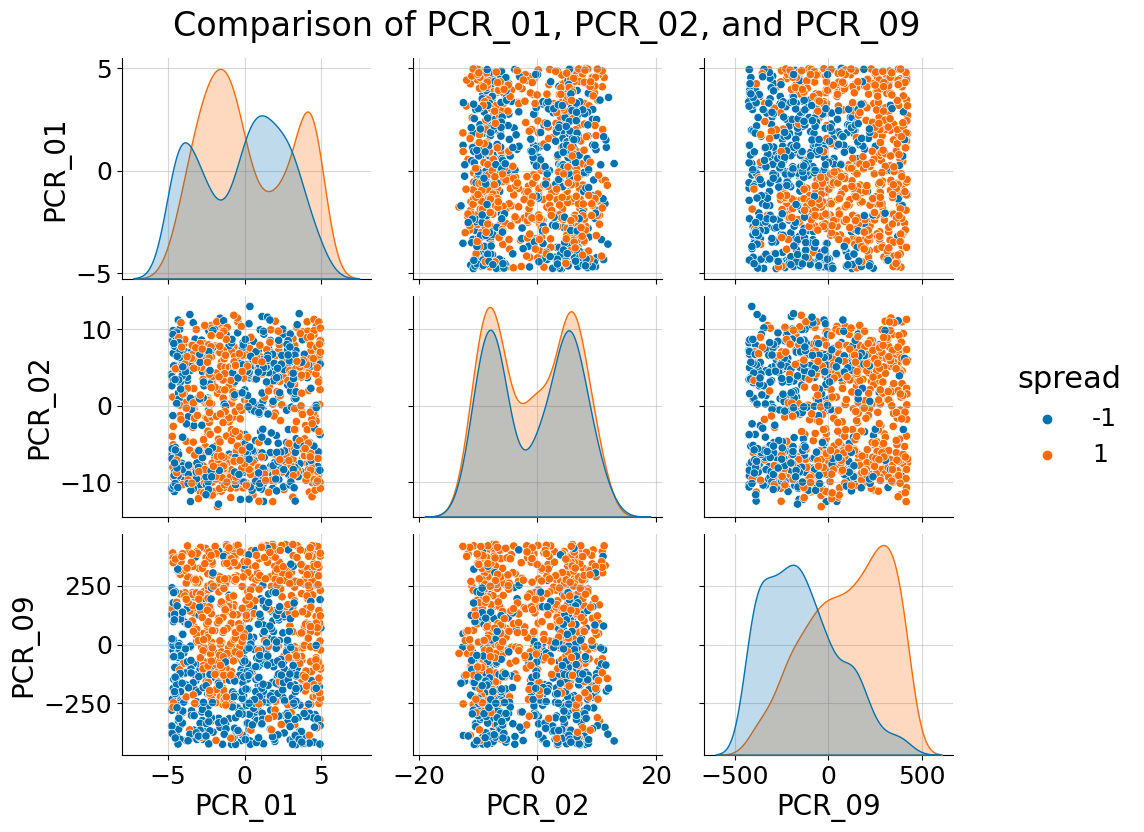

In [171]:
cols_to_compare = ['PCR_01', 'PCR_02', 'PCR_09']
custom_colors = ['#0072B2', '#FC6A03']
g = sns.pairplot(training, vars=cols_to_compare, hue="spread", diag_kind='kde', palette=custom_colors)
g.fig.suptitle("Comparison of PCR_01, PCR_02, and PCR_09", y=1.04)
for ax in np.ravel(g.axes):
    ax.grid(alpha=0.5)
g.fig.set_size_inches(12,8)

### Q7

In [172]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial.distance import cdist

def get_label(label):
    return np.sign(np.sum(label))

class kNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors: int = 3):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.copy(X)
        self.y_train = np.copy(y)
        return self

    def predict(self, X):
        predictions = None
        if self.X_train is not None and self.y_train is not None:
            dists = cdist(X, self.X_train, metric='euclidean')
            # get the indices of the k nearest neighbors
            k_indices = np.argpartition(dists, self.n_neighbors, axis=1)[
                :, :self.n_neighbors]

            # get the labels of the k nearest neighbors
            k_labels = self.y_train[k_indices]

            predictions = np.apply_along_axis(
                get_label, axis=1, arr=k_labels
            )
        return predictions

In [173]:
def visualize_clf(clf, X, Y, title,
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap

    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1, 1]):
        Y = (Y + 1) // 2
        labels = set(Y)

    assert labels == set([0, 1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()


### Q8

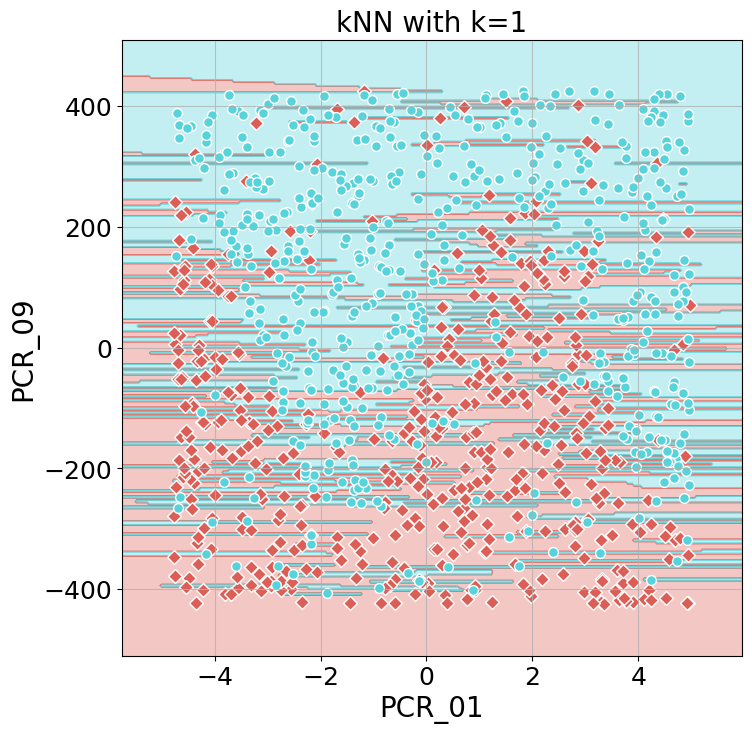

The kNN score on the training set is:  1.0
The kNN score on the test set is:  0.756


In [174]:
temp_data = training[['PCR_01', 'PCR_09']]
knn = kNN(1)
knn.fit(temp_data, training['spread'])
visualize_clf(knn, temp_data, training['spread'], 'kNN with k=1' ,'PCR_01', 'PCR_09')
print("The kNN score on the training set is: ",knn.score(temp_data, training['spread']))

temp_test = test[['PCR_01', 'PCR_09']]
print("The kNN score on the test set is: ",knn.score(temp_test, test['spread']))

### Q9

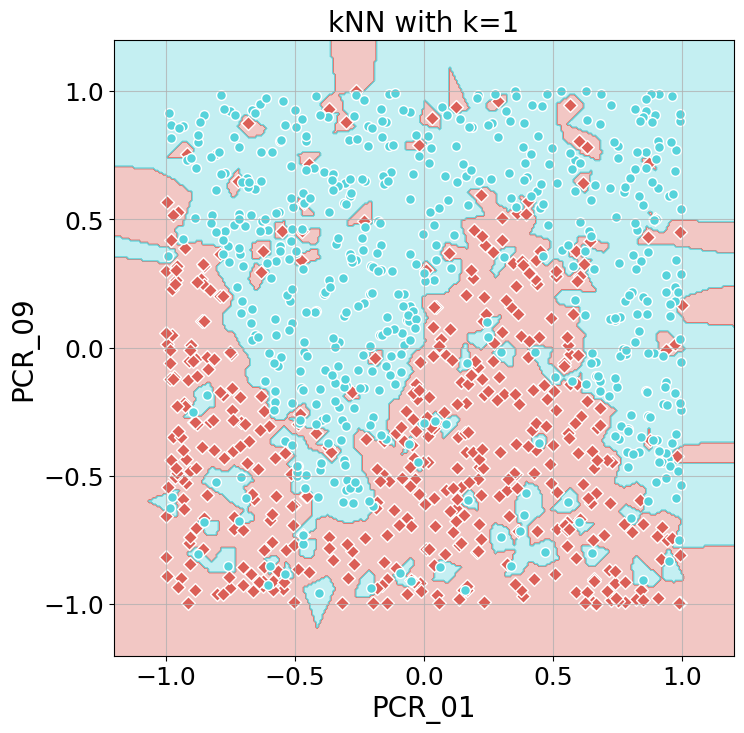

The kNN score on the training set after MinMax normalzing is:  1.0
The kNN score on the training set after MinMax normalzing is:  0.78


In [175]:
temp_data_normalized = MinMaxScaler(feature_range=(-1,1)).fit_transform(temp_data)
knn = kNN(1)
knn.fit(temp_data_normalized, training['spread'])
visualize_clf(knn, temp_data_normalized, training['spread'], 'kNN with k=1' ,'PCR_01', 'PCR_09')
print("The kNN score on the training set after MinMax normalzing is: ",
        knn.score(temp_data_normalized, training['spread']))

temp_data_test_normalized = MinMaxScaler(feature_range=(-1,1)).fit_transform(temp_test)
print("The kNN score on the training set after MinMax normalzing is: ",
        knn.score(temp_data_test_normalized, test['spread']))

### Q10

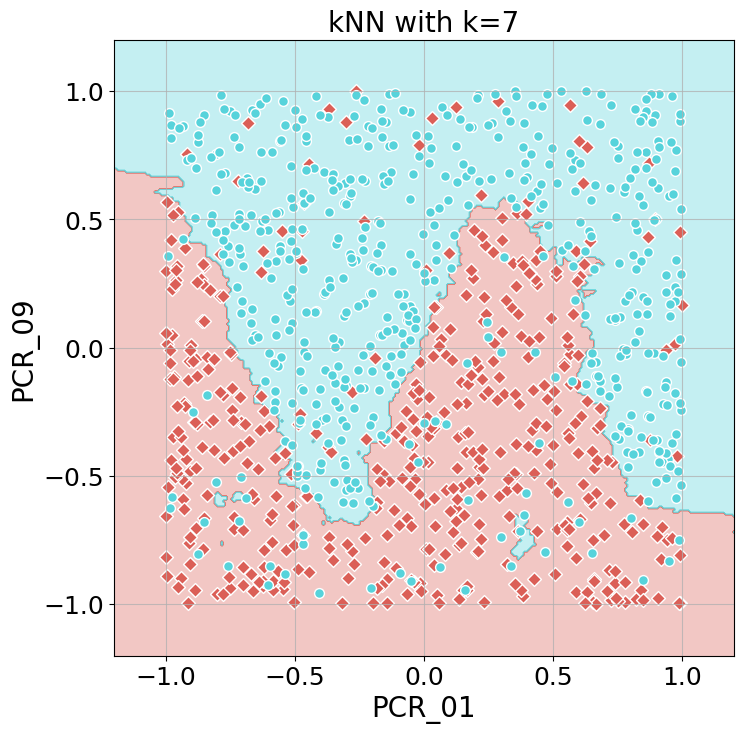

The kNN score on the training set after MinMax normalzing is:  0.884
The kNN score on the test set after MinMax normalzing is:  0.872


In [176]:
knn7 = kNN(7)
knn7.fit(temp_data_normalized, training['spread'])
visualize_clf(knn7, temp_data_normalized, training['spread'], 'kNN with k=7' ,'PCR_01', 'PCR_09')
print("The kNN score on the training set after MinMax normalzing is: ",
        knn7.score(temp_data_normalized, training['spread']))

print("The kNN score on the test set after MinMax normalzing is: ",
        knn7.score(temp_data_test_normalized, test['spread']))


## Part 3: Data Exploration


### Q13

Text(0, 0.5, 'Risk')

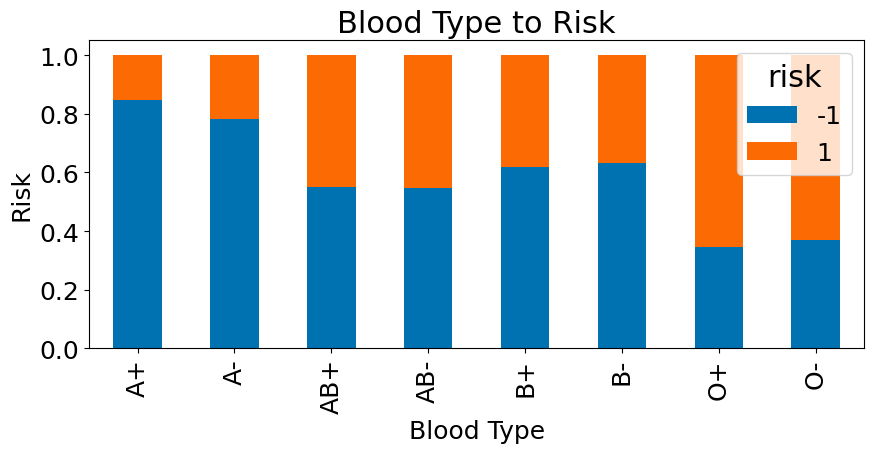

In [177]:
fig, ax1= plt.subplots(ncols=1, sharey=False, figsize=(10,4))
ax1.grid(alpha=0.5)
ax1.set_title("Blood Type to Risk", fontsize=22)
_ = pd.crosstab(training['blood_type'], training['risk'], normalize="index").plot(
                    kind='bar', stacked=True, ax=ax1, color=custom_colors)
ax1.set_xlabel("Blood Type", fontsize=18)
ax1.set_ylabel("Risk", fontsize=18)

change the blood_type filed to be a boolean features field

In [178]:
low_risk = ["A+", "A-"]
mid_risk = ["B+", "B-", "AB+", "AB-"]
high_risk = ["O+", "O-"]
training.loc[training['blood_type'].isin(low_risk), 'blood_type'] = -1
training.loc[training['blood_type'].isin(mid_risk), 'blood_type'] = 0
training.loc[training['blood_type'].isin(high_risk), 'blood_type'] = 1
training['blood_group'] = training['blood_type'].astype(int)
training.drop('blood_type', axis=1, inplace=True)


### Q14

split the symptoms

In [179]:
symptoms = training["symptoms"].str.split(";", expand=True).stack().unique()
for symptom in symptoms:
    training[symptom] = training["symptoms"].str.contains(symptom).fillna(0).replace({
        True: 1, False: -1}).astype(int)

training.drop(columns=["symptoms"], inplace=True)

split the current_location into x_location and y_location

In [180]:
# Define a function to extract the first and second values from the split arrays
def extract_values(arr):
    arr = arr[1:-1].split(',')
    x = float(arr[0].replace("'", '').replace(' ', ''))
    y = float(arr[1].replace("'", '').replace(' ', ''))
    return x,y

training[['x_location', 'y_location']] = training['current_location'].apply(
                                            lambda arr: pd.Series(extract_values(arr)))

training.drop(columns=['current_location'], inplace=True)

set the sex from categorical to 0/1

In [181]:
training.loc[training['sex'] == 'F', 'sex'] = -1
training.loc[training['sex'] == 'M', 'sex'] = 1

In [182]:
# Convert the 'date' column to a datetime column
training['pcr_date'] = pd.to_datetime(training['pcr_date'])

# Extract the integer values for the dates
training['pcr_date'] = (training['pcr_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

seting the spreed and risk to be the last columns

In [183]:
spread = training.pop('spread')
training['spread'] = spread
risk = training.pop('risk')
training['risk'] = risk

### Q15 and Q16

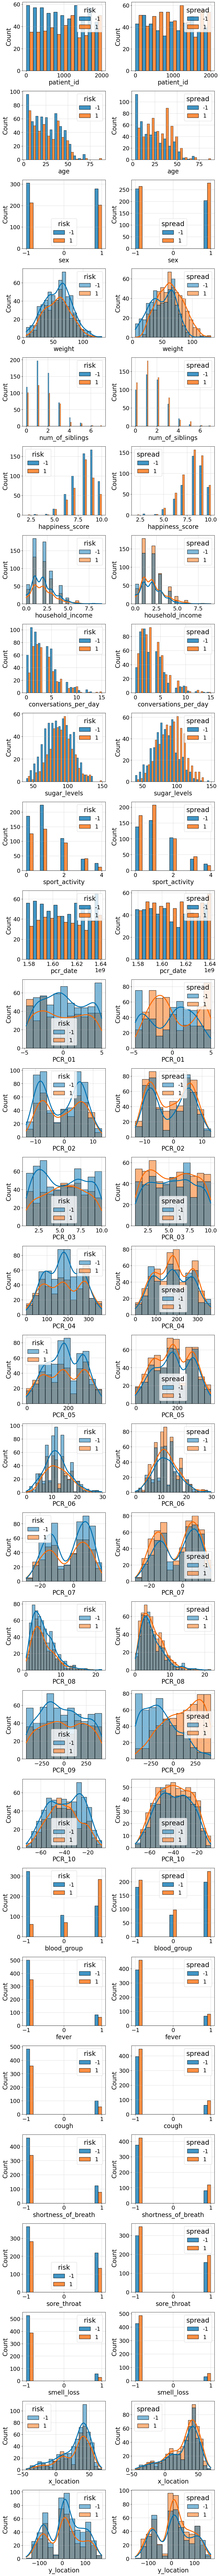

In [184]:
COL_NAME = training.columns
COL_NAME = COL_NAME.drop(['spread', 'risk'])
COLS, ROWS = (2, len(COL_NAME))
plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
    column = COL_NAME[row]
    for j, cls in enumerate(["risk", "spread"]):
        plt.subplot(ROWS,COLS, row * COLS + 1 + j)
        isContinuous = "float" in training[column].dtype.name
        sns.histplot(data=training, x=column, hue=cls, line_kws={"linewidth": 3},
        kde=isContinuous, multiple="layer" if isContinuous else "dodge", palette=custom_colors)
        plt.grid(alpha=0.5)
plt.tight_layout()

### Q17

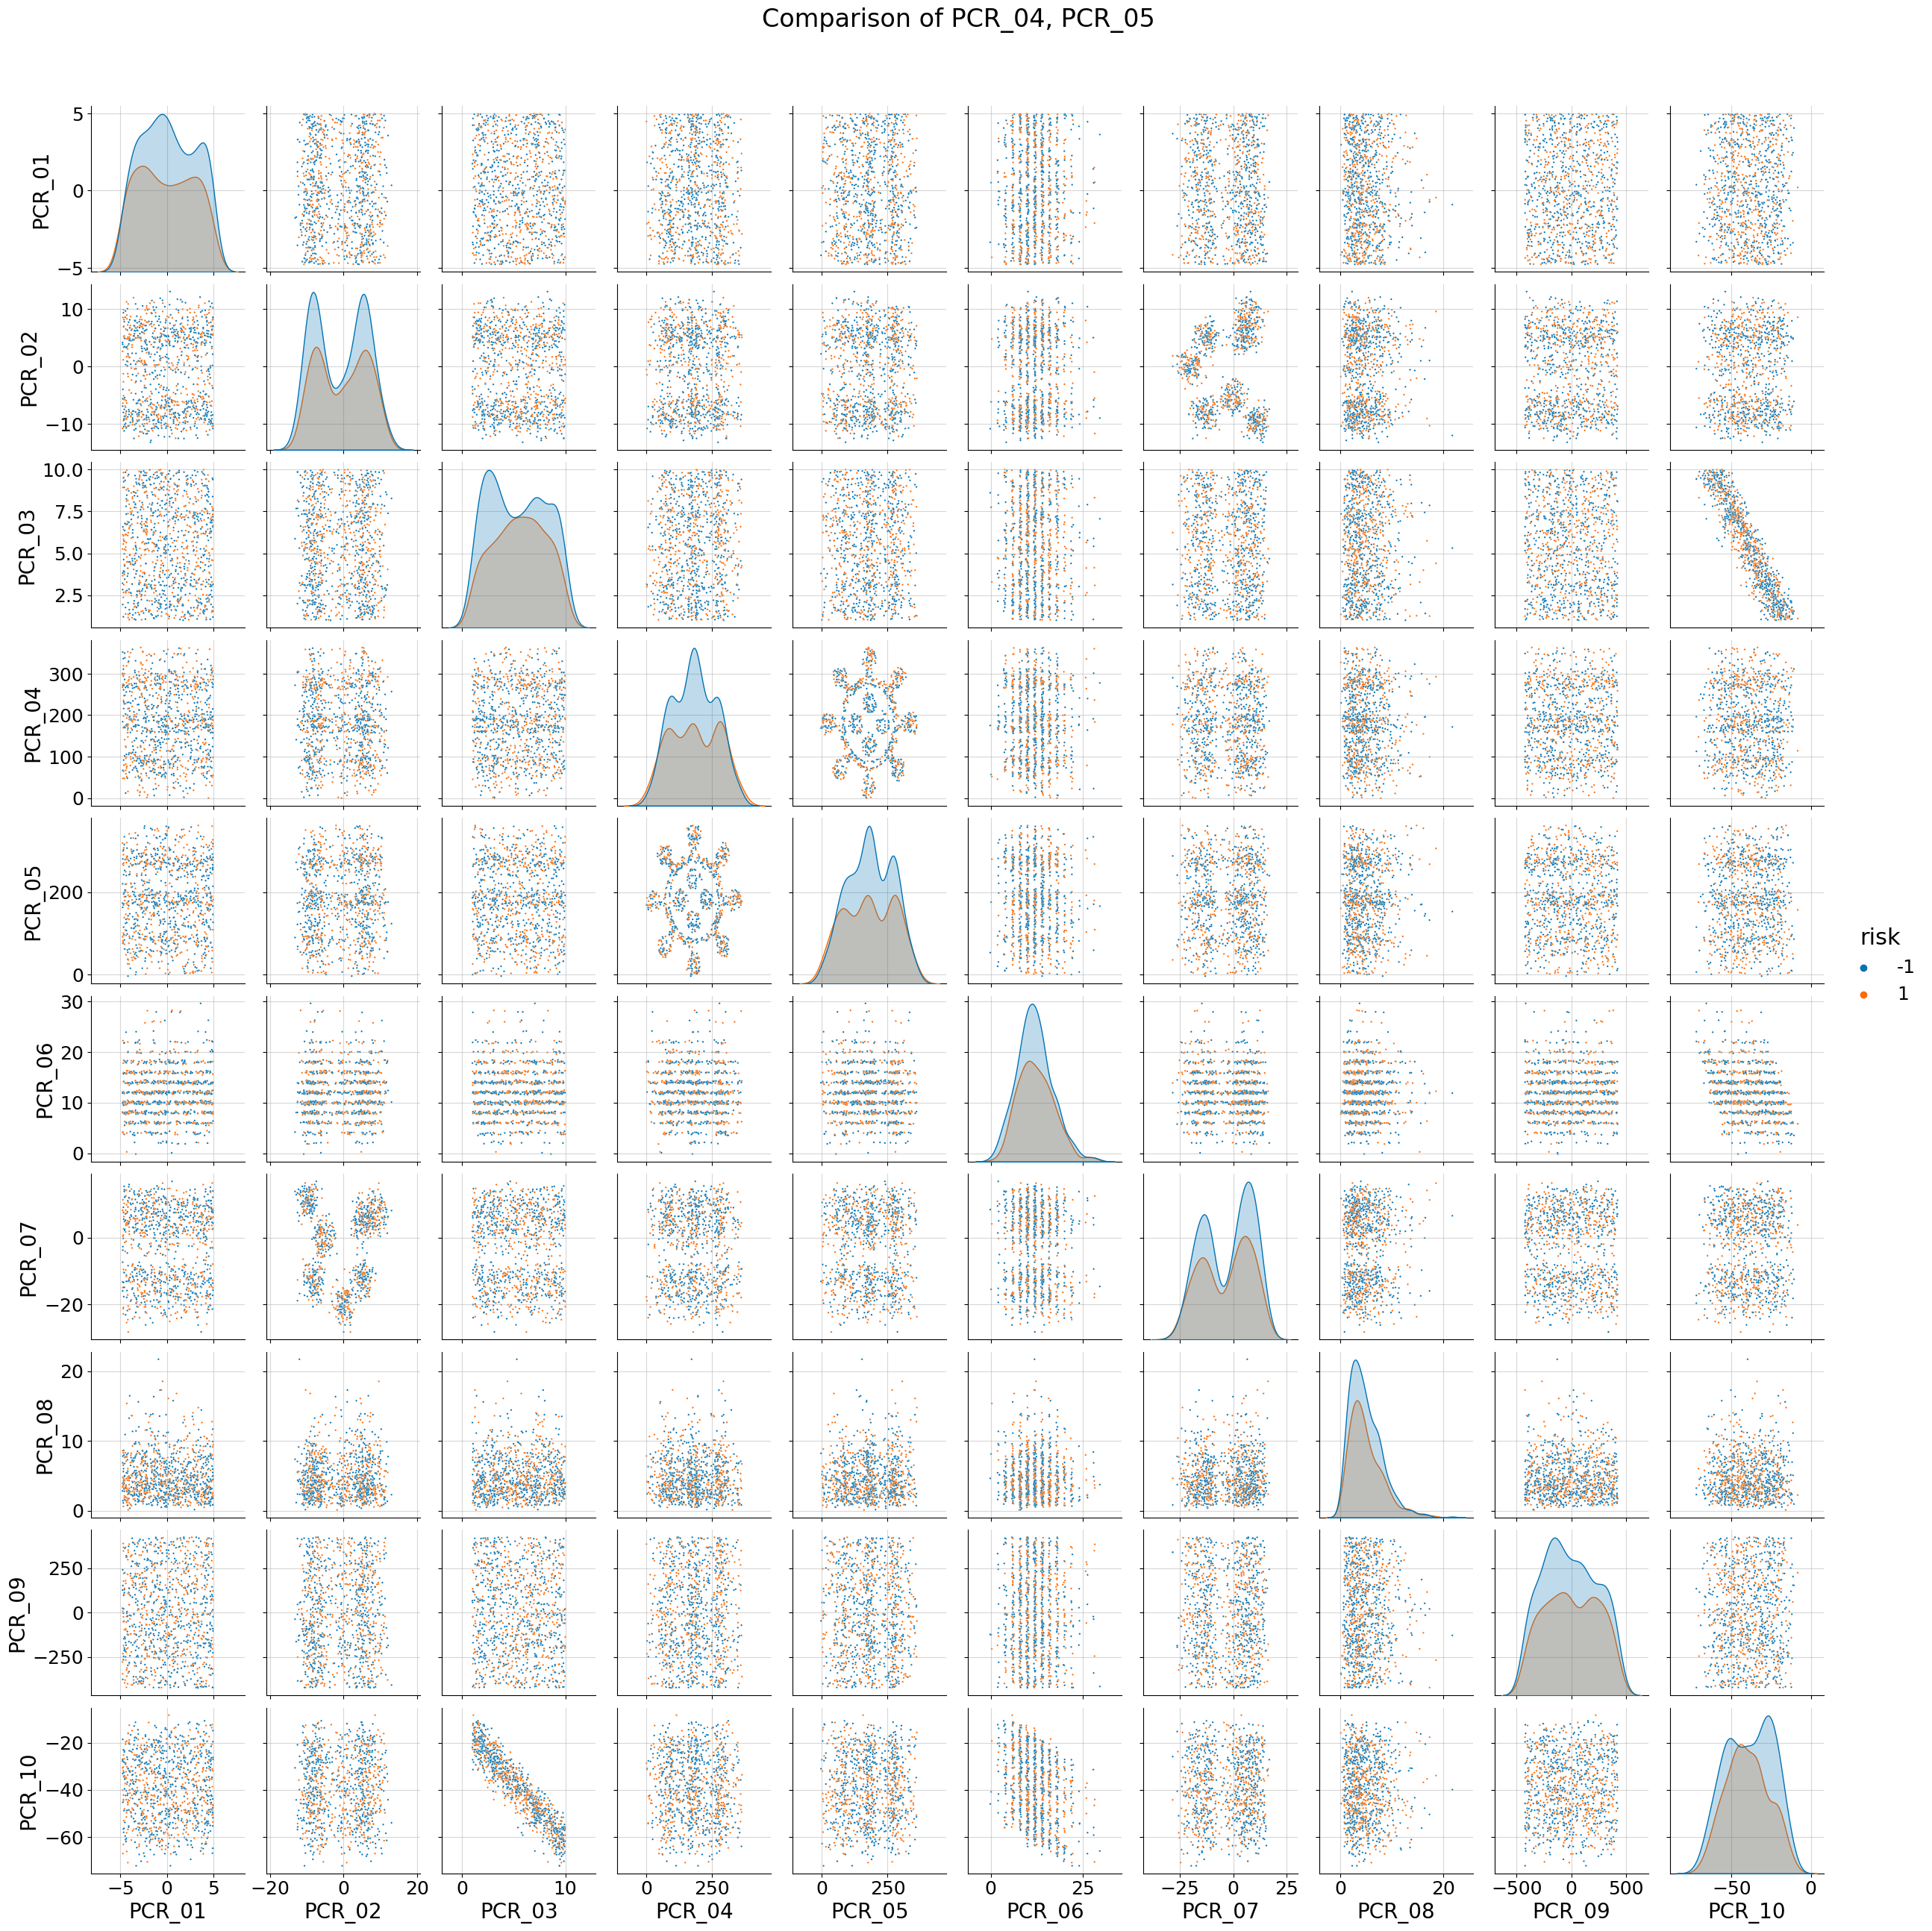

In [185]:
cols_to_compare = training.filter(like='PCR').columns.tolist() 
g = sns.pairplot(training, vars=cols_to_compare, hue="risk", diag_kind='kde', palette=custom_colors, plot_kws={"s": 3})
g.fig.suptitle("Comparison of PCR_04, PCR_05", y=1.04)
for ax in np.ravel(g.axes):
    ax.grid(alpha=0.5)

getting a better picture of the two paires of features

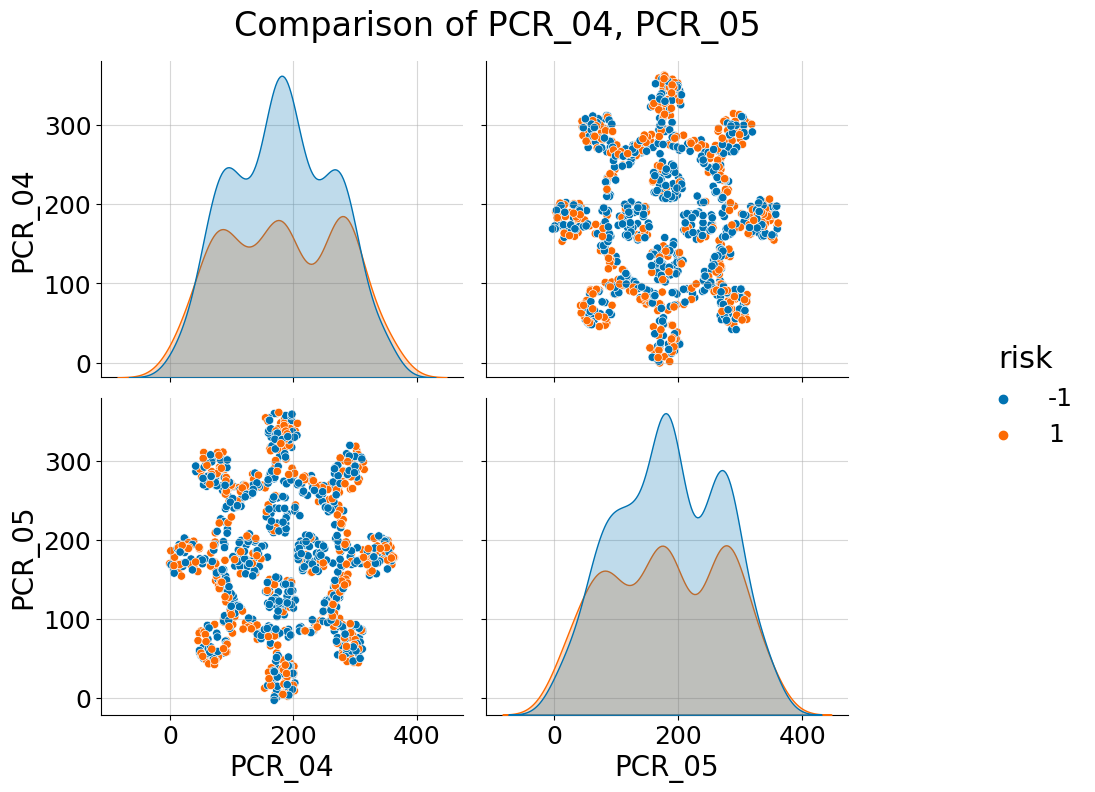

In [186]:
cols_to_compare = ['PCR_04', 'PCR_05']
g = sns.pairplot(training, vars=cols_to_compare, hue="risk", diag_kind='kde', palette=custom_colors)
g.fig.suptitle("Comparison of PCR_04, PCR_05", y=1.04)
for ax in np.ravel(g.axes):
    ax.grid(alpha=0.5)
g.fig.set_size_inches(12,8)

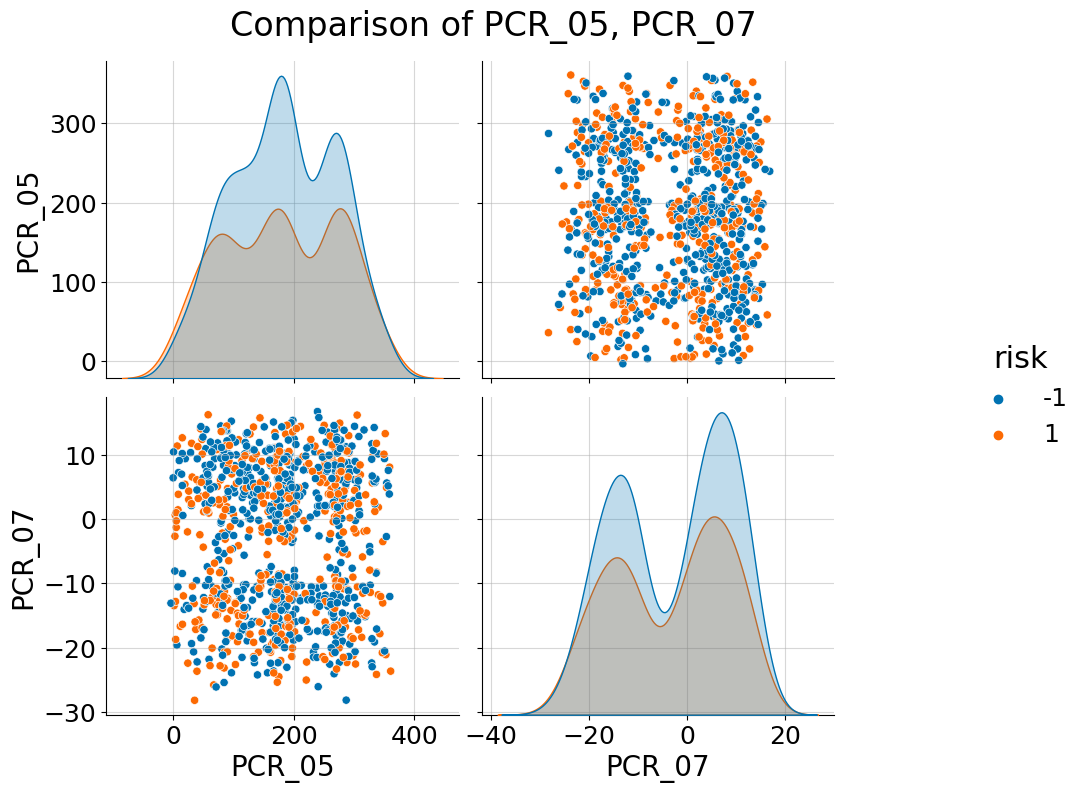

In [187]:
cols_to_compare = ['PCR_05', 'PCR_07']
g = sns.pairplot(training, vars=cols_to_compare, hue="risk", diag_kind='kde', palette=custom_colors)
g.fig.suptitle("Comparison of PCR_05, PCR_07", y=1.04)
for ax in np.ravel(g.axes):
    ax.grid(alpha=0.5)
g.fig.set_size_inches(12,8)

### Q18

In [188]:
# Get the unique values of blood_group
blood_groups = training['blood_group'].unique()
blood_group_names = {-1: 'A+, A-', 0: 'B+, B-, AB+, AB-', 1: 'O+, O-'}


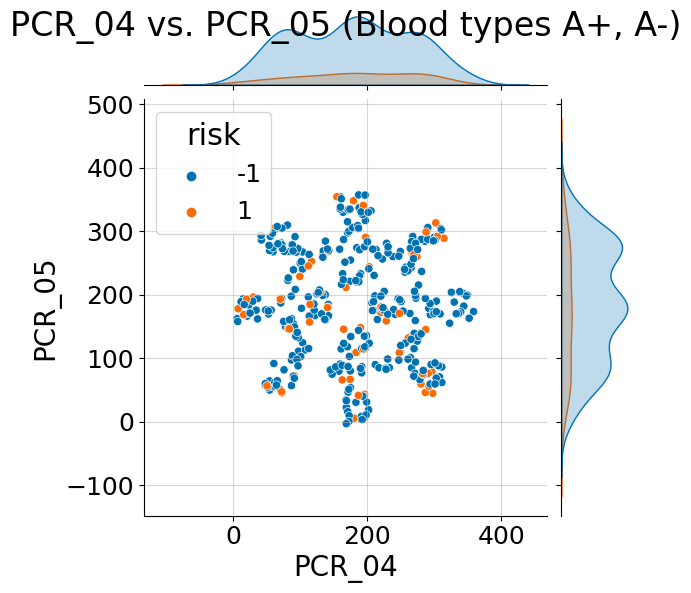

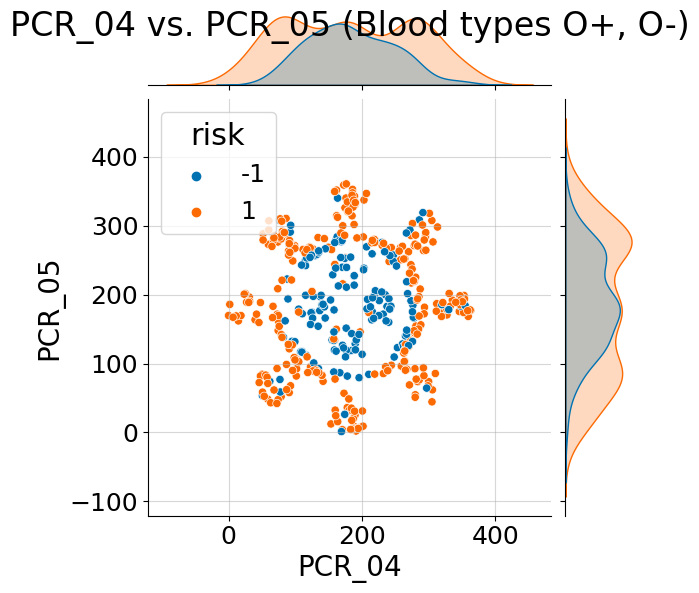

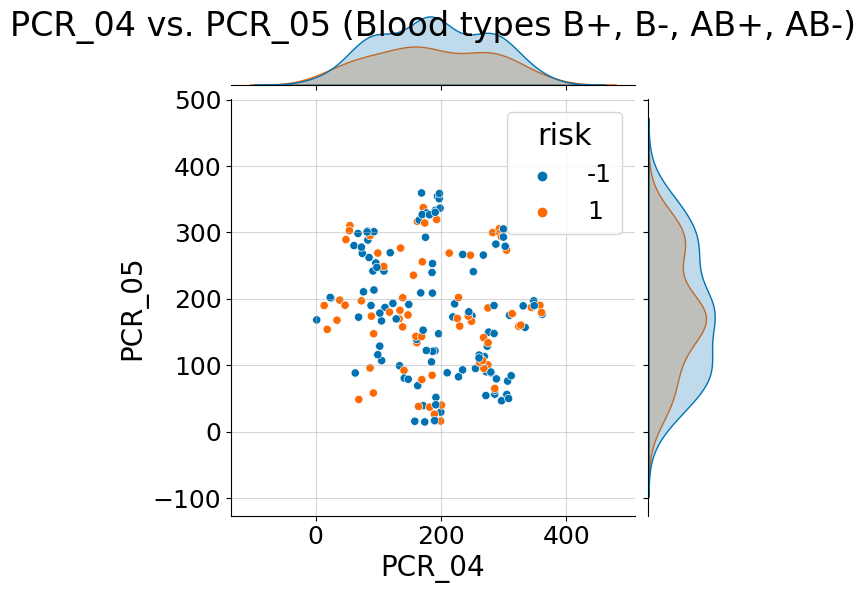

In [189]:
# Create a jointplot for each blood group PCR_04 and PCR_05
for blood_group in blood_groups:
    g = sns.jointplot(data=training[training['blood_group'] == blood_group], 
                        x='PCR_04', y='PCR_05', hue='risk', palette=custom_colors)
    g.fig.suptitle("PCR_04 vs. PCR_05 (Blood types {})".format(blood_group_names[blood_group]))
    g.ax_joint.grid(alpha=0.5)


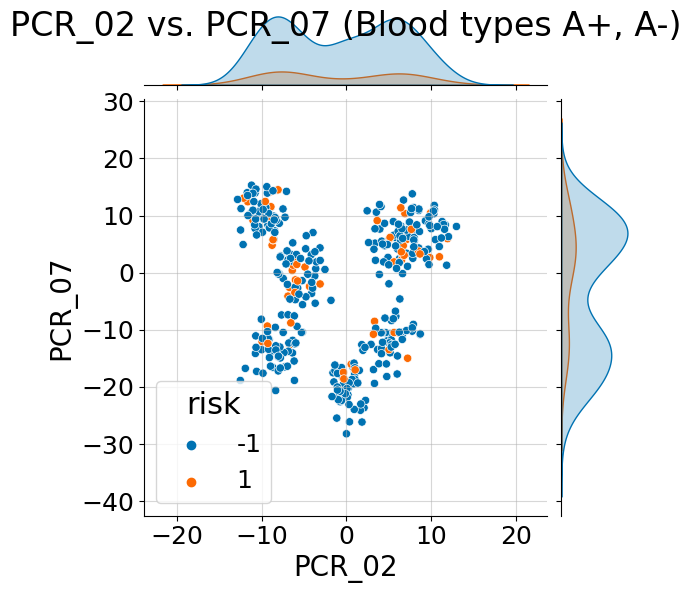

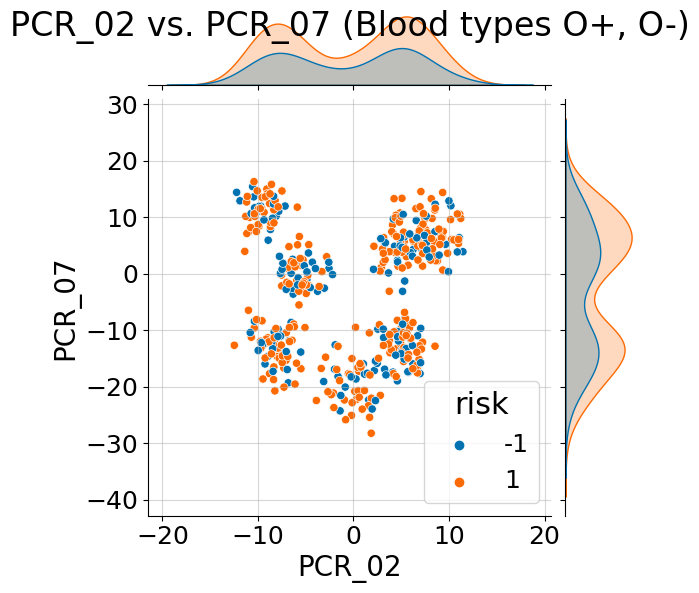

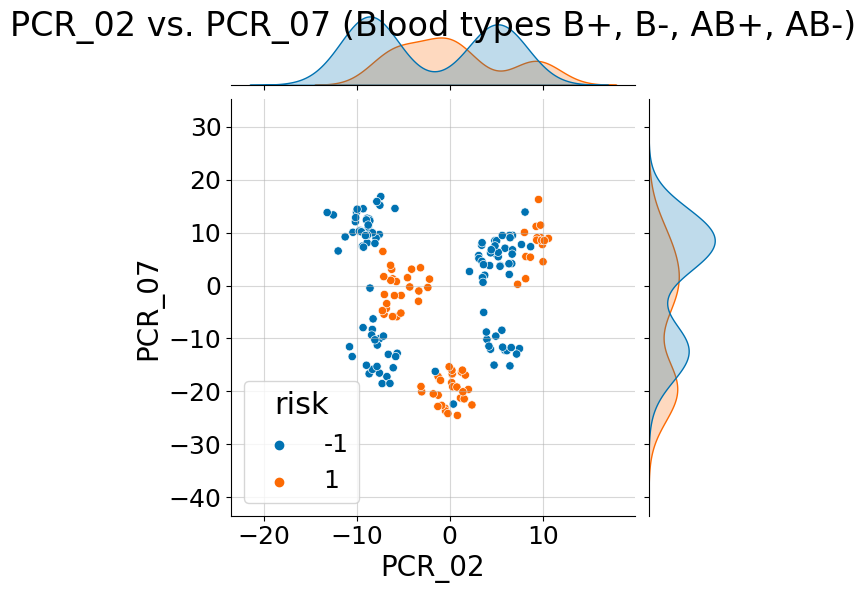

In [190]:

# Create a jointplot for each blood group PCR_02 and PCR_07
for blood_group in blood_groups:
    g = sns.jointplot(data=training[training['blood_group'] == blood_group], 
                        x='PCR_02', y='PCR_07', hue='risk', palette=custom_colors)
    g.fig.suptitle("PCR_02 vs. PCR_07 (Blood types {})".format(blood_group_names[blood_group]))
    g.ax_joint.grid(alpha=0.5)


## Part 4: More Data Normalization

### Q20

#### printing ages before normalization

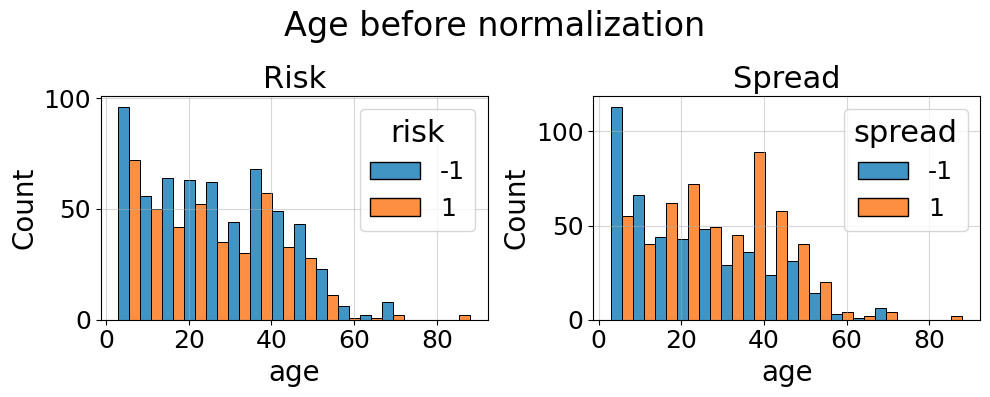

In [191]:
COLS, ROWS = (2, 1)
plt.figure(figsize=(5 * COLS, 4 * ROWS))
column = 'age'
for j, cls in enumerate(["risk", "spread"]):
    plt.subplot(ROWS, COLS, j+1)
    isContinuous = "float" in training[column].dtype.name
    sns.histplot(data=training, x=column, hue=cls, line_kws={"linewidth": 3},
    kde=isContinuous, multiple="layer" if isContinuous else "dodge", palette=custom_colors)
    plt.grid(alpha=0.5)
    plt.title(f"{cls.capitalize()}")
plt.suptitle("Age before normalization")
plt.tight_layout()


#### normalizing 

In [192]:
min_max_columns = ['patient_id', 'sport_activity', 'pcr_date', 'PCR_01',
                    'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_07', 
                    'PCR_09', 'PCR_10']
standard_columns = ['age', 'weight', 'num_of_siblings', 'happiness_score',
                    'household_income', 'conversations_per_day', 'sugar_levels',
                    'PCR_06', 'PCR_08', 'x_location', 'y_location']

In [193]:
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
standard_scaler = StandardScaler()

In [194]:
training[min_max_columns] = min_max_scaler.fit_transform(training[min_max_columns])
training[standard_columns] = standard_scaler.fit_transform(training[standard_columns])

#### printing ages after normalization

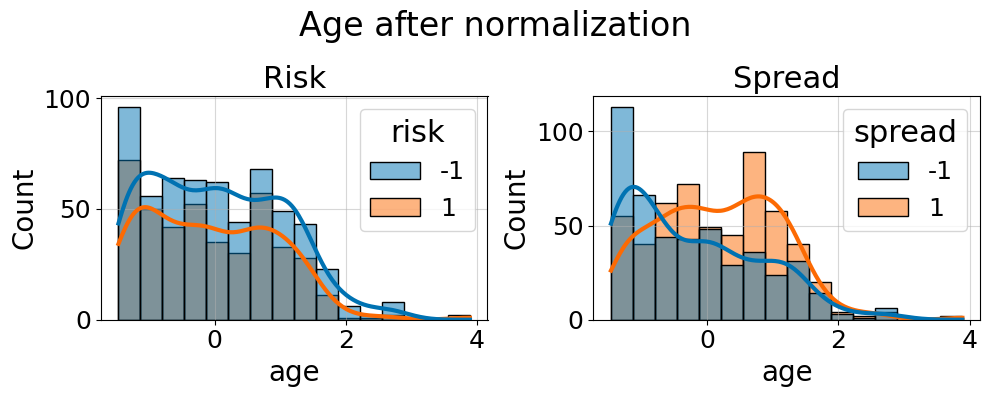

In [195]:
COLS, ROWS = (2, 1)
plt.figure(figsize=(5 * COLS, 4 * ROWS))
column = 'age'
for j, cls in enumerate(["risk", "spread"]):
    plt.subplot(ROWS, COLS, j+1)
    isContinuous = "float" in training[column].dtype.name
    sns.histplot(data=training, x=column, hue=cls, line_kws={"linewidth": 3},
    kde=isContinuous, multiple="layer" if isContinuous else "dodge", palette=custom_colors)
    plt.grid(alpha=0.5)
    plt.title(f"{cls.capitalize()}")
plt.suptitle("Age after normalization")
plt.tight_layout()


## Part 5: Feature Selection

### Q23

In [196]:
sklearn_knn = KNeighborsClassifier(n_neighbors=5)
sfs_forward = SequentialFeatureSelector(
    sklearn_knn, n_features_to_select=3, direction="forward"
    ).fit(training.drop(['risk', 'spread'], axis=1), training['spread'])

sfs_forward.get_support()

array([False, False, False,  True, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False])

In [197]:
training.columns

Index(['patient_id', 'age', 'sex', 'weight', 'num_of_siblings',
       'happiness_score', 'household_income', 'conversations_per_day',
       'sugar_levels', 'sport_activity', 'pcr_date', 'PCR_01', 'PCR_02',
       'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09',
       'PCR_10', 'blood_group', 'fever', 'cough', 'shortness_of_breath',
       'sore_throat', 'smell_loss', 'x_location', 'y_location', 'spread',
       'risk'],
      dtype='object')

In [198]:
selected_cols = training.drop(['risk', 'spread'], axis=1).columns[sfs_forward.get_support()]
selected_cols


Index(['weight', 'PCR_01', 'PCR_09'], dtype='object')

## Part 6: Data Preparation Pipeline

### Q25